In [ ]:
import pandas as pd 
import numpy as np
import os
ress2_b = pd.read_csv('prediction/vitL16M1_M1all_prediction_sub512_2048log2LB_#layers2_emb512_s2_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })
resl8_b = pd.read_csv('prediction/vitL16M1_M1all_prediction_sub512_2048log2LB_#layers2_emb512_l8_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })
ress2_l = pd.read_csv('prediction/lgbm_vitL16M1_M1all_prediction_sub512_2048log2LB_#layers2_emb512_s2_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })
resl8_l = pd.read_csv('prediction/lgbm_vitL16M1_M1all_prediction_sub512_2048log2LB_#layers2_emb512_l8_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })

population = pd.read_csv("/data/Population_us/DECENNIALDHC2020.P1-Data.csv", header=1)
population = population.rename(columns={' !!Total': 'population'})
population['geoid'] = population['Geography'].apply(lambda x:str(x)[-11:])
res_total = pd.concat([
           ress2_b.set_index(['h_geocode','w_geocode']),
           resl8_b.set_index(['h_geocode','w_geocode']),
           ress2_l.set_index(['h_geocode','w_geocode']),
           resl8_l.set_index(['h_geocode','w_geocode']),
           ]
           , axis=1, join="inner")
res_total.drop(columns='Unnamed: 0', inplace=True)
res_total.columns = ['count', 'prediction_bilinear_s2', 'c1', 'prediction_bilinear_l8',
                      'c2', 'prediction_lgbm_s2', 'c3', 'prediction_lgbm_l8']
res_total.drop(columns=['c1', 'c2', 'c3']
               ,inplace=True)
res_total = res_total.reset_index()
res_total

In [2]:
# Land use
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

shapefile_path =  '/data/Landuse/Tabulat_LU_M1.dbf' # 2327
lu = gpd.read_file(shapefile_path)
lu = pd.DataFrame(lu)
lu = lu.set_index('GEOID20')
# lu = lu.drop(columns='geometry')
lu['max_class'] = lu.idxmax(axis=1)
for i in res_total['h_geocode'].unique():
    try:
        res_total.loc[res_total['h_geocode']==i, 'LU'] = lu.loc[str(i)]['max_class']
    except KeyError:
        res_total.loc[res_total['h_geocode']==i, 'LU'] = 'UNKNOWN'

In [ ]:
# Land Cover
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

shapefile_path = '/data/Landuse/Tabulat_value_M1.dbf' 
gdf_lu = gpd.read_file(shapefile_path)
gdf_lu = gdf_lu.set_index('GEOID20')


gdf_lu['SUM_22_23_24'] = gdf_lu['VALUE_22'] + gdf_lu['VALUE_23'] + gdf_lu['VALUE_24']
gdf_lu['SUM_4'] = gdf_lu['VALUE_41'] + gdf_lu['VALUE_42'] + gdf_lu['VALUE_43']
gdf_lu['SUM_8'] = gdf_lu['VALUE_81'] + gdf_lu['VALUE_82']
gdf_lu['SUM_9'] = gdf_lu['VALUE_90'] + gdf_lu['VALUE_95']

gdf_lu = gdf_lu[['VALUE_0', 'VALUE_11', 'VALUE_21', 'SUM_22_23_24', 'VALUE_31', 'SUM_4', 'VALUE_52', 'VALUE_71', 'SUM_8', 'SUM_9']]
gdf_lu['max_class'] = gdf_lu.idxmax(axis=1)

In [ ]:
# population
population = population[population['geoid'].isin(res_total['h_geocode'].unique())]
labels_p = [ i for i in range(10, 0, -1) ]
population['Decile_rank'] = pd.qcut(population['population'], 10, 
                            labels = labels_p)
population = population.set_index('geoid')

In [8]:
# res_total['common_r1w'] = res_total[['prediction_r1w','count']].min(axis=1)
res_total['common_bilinear_s2'] = res_total[['prediction_bilinear_s2','count']].min(axis=1)
res_total['common_bilinear_l8'] = res_total[['prediction_bilinear_l8','count']].min(axis=1)
res_total['common_lgbm_s2'] = res_total[['prediction_lgbm_s2','count']].min(axis=1)
res_total['common_lgbm_l8'] = res_total[['prediction_lgbm_l8','count']].min(axis=1)

In [ ]:
home_sum = res_total.groupby('h_geocode').sum()
for index, row in home_sum.iterrows():
    home_sum.at[index, 'population'] = population.loc[str(index)]['population']
    home_sum.at[index, 'decile'] = population.loc[str(index)]['Decile_rank']
    try:
        home_sum.at[index, 'LC'] = gdf_lu.loc[str(index)]['max_class']
    except KeyError:
        home_sum.at[index, 'LC'] = 'UNKNOWN'
    try:
        home_sum.at[index, 'LU'] = lu.loc[str(index)]['max_class']
    except KeyError:
        home_sum.at[index, 'LU'] = 'UNKNOWN'
# home_sum['h_cpc_r1w'] = 2 * home_sum['common_r1w'] / (home_sum['count']+home_sum['prediction_r1w'])
home_sum['h_cpc_bilinear_s2'] = 2 * home_sum['common_bilinear_s2'] / (home_sum['count']+home_sum['prediction_bilinear_s2'])
home_sum['h_cpc_bilinear_l8'] = 2 * home_sum['common_bilinear_l8'] / (home_sum['count']+home_sum['prediction_bilinear_l8'])
home_sum['h_cpc_lgbm_s2'] = 2 * home_sum['common_lgbm_s2'] / (home_sum['count']+home_sum['prediction_lgbm_s2'])
home_sum['h_cpc_lgbm_l8'] = 2 * home_sum['common_lgbm_l8'] / (home_sum['count']+home_sum['prediction_lgbm_l8'])


In [11]:
home_sum2 = home_sum
home_sum2['LU'] = home_sum2['LU'].apply(lambda x: 'VALUE_5' if x=='VALUE_6' else x)

    decile count  CPC bilinear s2 mean  CPC bilinear l8 mean  \
0  VALUE_2   440              0.822689              0.816609   
0  VALUE_3    68              0.813608              0.805588   
0  VALUE_4     7              0.761803              0.763962   
0  VALUE_5  4128              0.810665              0.806236   

   CPC lgbm s2 mean  CPC lgbm l8 mean  
0          0.836270          0.832175  
0          0.822732          0.811027  
0          0.790434          0.788389  
0          0.837334          0.833867  
LGBM


C:\Users\1OrangeGo\AppData\Local\Temp\ipykernel_10848\2176589081.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, newrow])


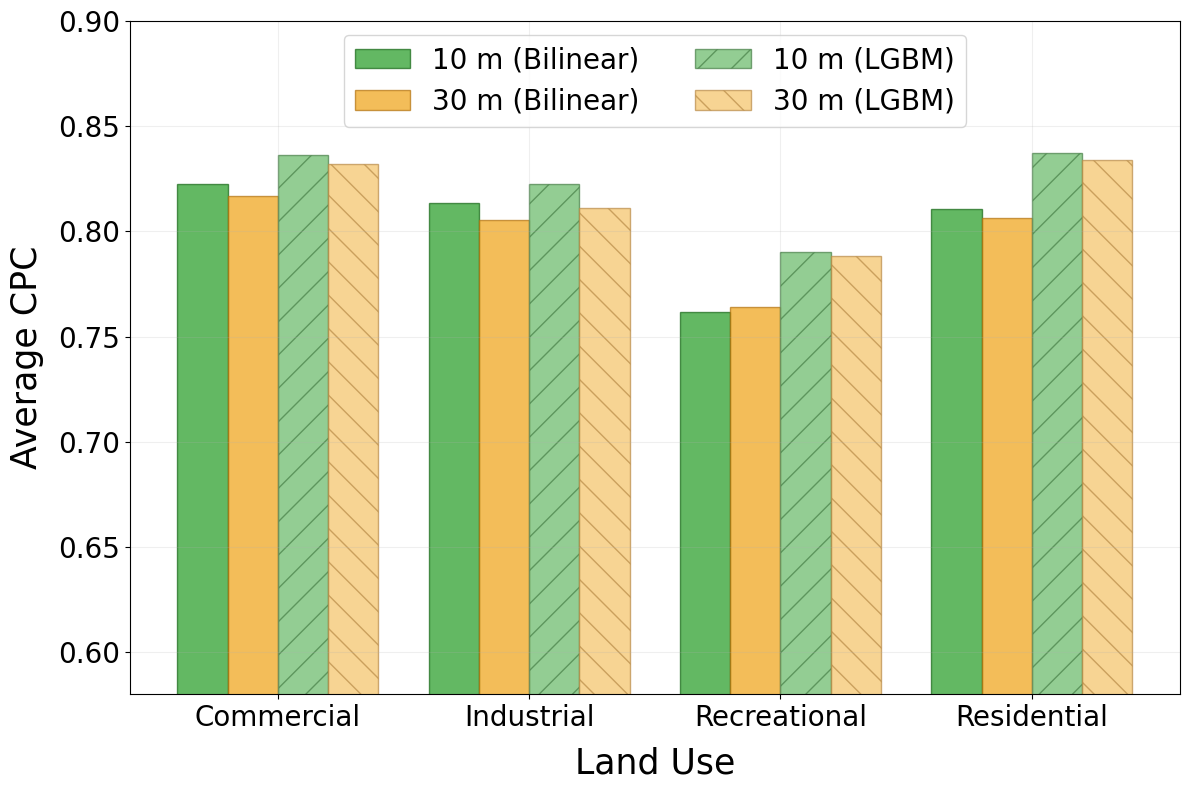

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns


column_name = 'LU'
axisx_label = 'Land Use'
x_ticklabels = [ 'Commercial','Industrial', 'Recreational', 'Residential']
df = home_sum2
x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_b_s2s,std_b_l8s,std_l_s2s,std_l_l8s = [], [], [], []

table = pd.DataFrame(columns=['decile','count', 'CPC bilinear s2 mean','CPC bilinear l8 mean', 'CPC lgbm s2 mean','CPC lgbm l8 mean'])

for decile in ['VALUE_2', 'VALUE_3', 'VALUE_4', 'VALUE_5']:
    df_temp = df[df[column_name] == decile]


    avg_b_s2 = df_temp.h_cpc_bilinear_s2.mean()
    avg_b_l8 = df_temp.h_cpc_bilinear_l8.mean()
    avg_l_s2 = df_temp.h_cpc_lgbm_s2.mean()
    avg_l_l8 = df_temp.h_cpc_lgbm_l8.mean()

    std_b_s2 = df_temp.h_cpc_bilinear_s2.std()
    std_b_l8 = df_temp.h_cpc_bilinear_l8.std()
    std_l_s2 = df_temp.h_cpc_lgbm_s2.std()
    std_l_l8 = df_temp.h_cpc_lgbm_l8.std()


    std_b_s2s.append(std_b_s2)
    std_b_l8s.append(std_b_l8)
    std_l_s2s.append(std_l_s2)
    std_l_l8s.append(std_l_l8)

    newrow = pd.DataFrame([[decile, len(df_temp), avg_b_s2, avg_b_l8, avg_l_s2, avg_l_l8]], 
                          columns=['decile', 'count',  'CPC bilinear s2 mean','CPC bilinear l8 mean', 'CPC lgbm s2 mean', 'CPC lgbm l8 mean'])

    table = pd.concat([table, newrow])

print(table)
index = np.arange(len(x_ticklabels))
bar_width=0.2

ax.bar(index - 0.3, table['CPC bilinear s2 mean'], bar_width, label=f'10 m (Bilinear)',linewidth=1,
        color = '#219a21', edgecolor='#156615', alpha=0.7) #, yerr = std_b_s2s)
ax.bar(index - 0.1, table['CPC bilinear l8 mean'], bar_width, label=f'30 m (Bilinear)',linewidth=1,
        color = '#efa112', edgecolor='#b3710c', alpha=0.7) 
ax.bar(index + 0.1, table['CPC lgbm s2 mean'], bar_width, label=f'10 m (LGBM)',linewidth=1,
        color = '#66b966', edgecolor='#477f47', alpha=0.7, hatch='/') #  hatch='\\',
ax.bar(index + 0.3, table['CPC lgbm l8 mean'], bar_width, label=f'30 m (LGBM)', linewidth=1,
       color = '#f5c266', edgecolor='#b88a46', alpha=0.7, hatch='\\')


ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0.58,0.90)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)

ax.legend(fontsize=20, loc='upper center', ncols=2)

plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
print('LGBM')


         decile count CPC s2 mean CPC l8 mean  CPC bilinear s2 mean  \
0      VALUE_21   171         NaN         NaN              0.784305   
0  SUM_22_23_24  4045         NaN         NaN              0.818351   
0         SUM_4   277         NaN         NaN              0.758880   
0         SUM_8    22         NaN         NaN              0.746674   
0         SUM_9    40         NaN         NaN              0.771457   

   CPC bilinear l8 mean  CPC lgbm s2 mean  CPC lgbm l8 mean  
0              0.785410          0.825611          0.825425  
0              0.813312          0.841608          0.837857  
0              0.753495          0.805957          0.802336  
0              0.730706          0.835265          0.824558  
0              0.775393          0.813659          0.814984  
LGBM


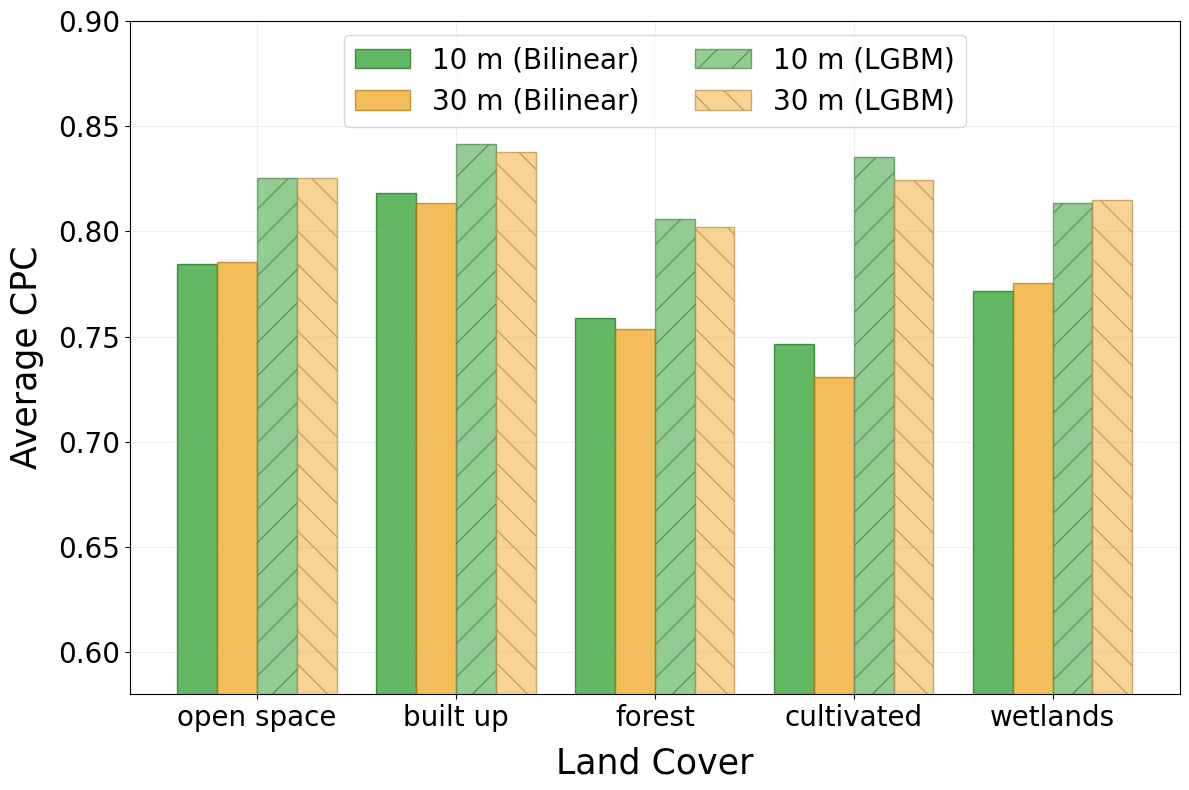

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json

column_name = 'LC'
axisx_label = 'Land Cover'

x_ticklabels = ['open space', 'built up', 'forest', 'cultivated', 'wetlands']
df = home_sum
x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []

table = pd.DataFrame(columns=['decile', 'count',  'CPC bilinear s2 mean','CPC bilinear l8 mean', 'CPC lgbm s2 mean', 'CPC lgbm l8 mean'])

for decile in ['VALUE_21', 'SUM_22_23_24', 'SUM_4', 'SUM_8', 'SUM_9']:
    df_temp = df[df[column_name] == decile]

    avg_b_s2 = df_temp.h_cpc_bilinear_s2.mean()
    avg_b_l8 = df_temp.h_cpc_bilinear_l8.mean()
    avg_l_s2 = df_temp.h_cpc_lgbm_s2.mean()
    avg_l_l8 = df_temp.h_cpc_lgbm_l8.mean()
    
    std_b_s2 = df_temp.h_cpc_bilinear_s2.std()
    std_b_l8 = df_temp.h_cpc_bilinear_l8.std()
    std_l_s2 = df_temp.h_cpc_lgbm_s2.std()
    std_l_l8 = df_temp.h_cpc_lgbm_l8.std()


    std_b_s2s.append(std_b_s2)
    std_b_l8s.append(std_b_l8)
    std_l_s2s.append(std_l_s2)
    std_l_l8s.append(std_l_l8)

    newrow = pd.DataFrame([[decile, len(df_temp), avg_b_s2, avg_b_l8, avg_l_s2, avg_l_l8]], 
                          columns=['decile', 'count',  'CPC bilinear s2 mean','CPC bilinear l8 mean', 'CPC lgbm s2 mean', 'CPC lgbm l8 mean'])

    table = pd.concat([table, newrow])

print(table)
index = np.arange(len(x_ticklabels))
bar_width=0.2

ax.bar(index - 0.3, table['CPC bilinear s2 mean'], bar_width, label=f'10 m (Bilinear)',linewidth=1,
        color = '#219a21', edgecolor='#156615', alpha=0.7) #, yerr = std_b_s2s)
ax.bar(index - 0.1, table['CPC bilinear l8 mean'], bar_width, label=f'30 m (Bilinear)',linewidth=1,
        color = '#efa112', edgecolor='#b3710c', alpha=0.7) 
ax.bar(index + 0.1, table['CPC lgbm s2 mean'], bar_width, label=f'10 m (LGBM)',linewidth=1,
        color = '#66b966', edgecolor='#477f47', alpha=0.7, hatch='/') #  hatch='\\',
ax.bar(index + 0.3, table['CPC lgbm l8 mean'], bar_width, label=f'30 m (LGBM)', linewidth=1,
       color = '#f5c266', edgecolor='#b88a46', alpha=0.7, hatch='\\')

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0.58,0.90)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)

ax.legend(fontsize=20, loc='upper center', ncols=2)

plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
print('LGBM')

   decile count  CPC bilinear s2 mean  CPC bilinear l8 mean  CPC lgbm s2 mean  \
0     1.0   479              0.783546              0.780646          0.820067   
0     2.0   478              0.790188              0.788575          0.834470   
0     3.0   478              0.800511              0.794885          0.840311   
0     4.0   478              0.811354              0.804487          0.849059   
0     5.0   478              0.813044              0.810142          0.848994   
0     6.0   479              0.817322              0.812356          0.849467   
0     7.0   479              0.819864              0.815350          0.844627   
0     8.0   477              0.821357              0.814337          0.839754   
0     9.0   481              0.829608              0.828444          0.831758   
0    10.0   479              0.820136              0.811320          0.804781   

   CPC lgbm l8 mean  
0          0.815046  
0          0.831891  
0          0.837551  
0          0.845163 

C:\Users\1OrangeGo\AppData\Local\Temp\ipykernel_22028\2667220505.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, newrow])


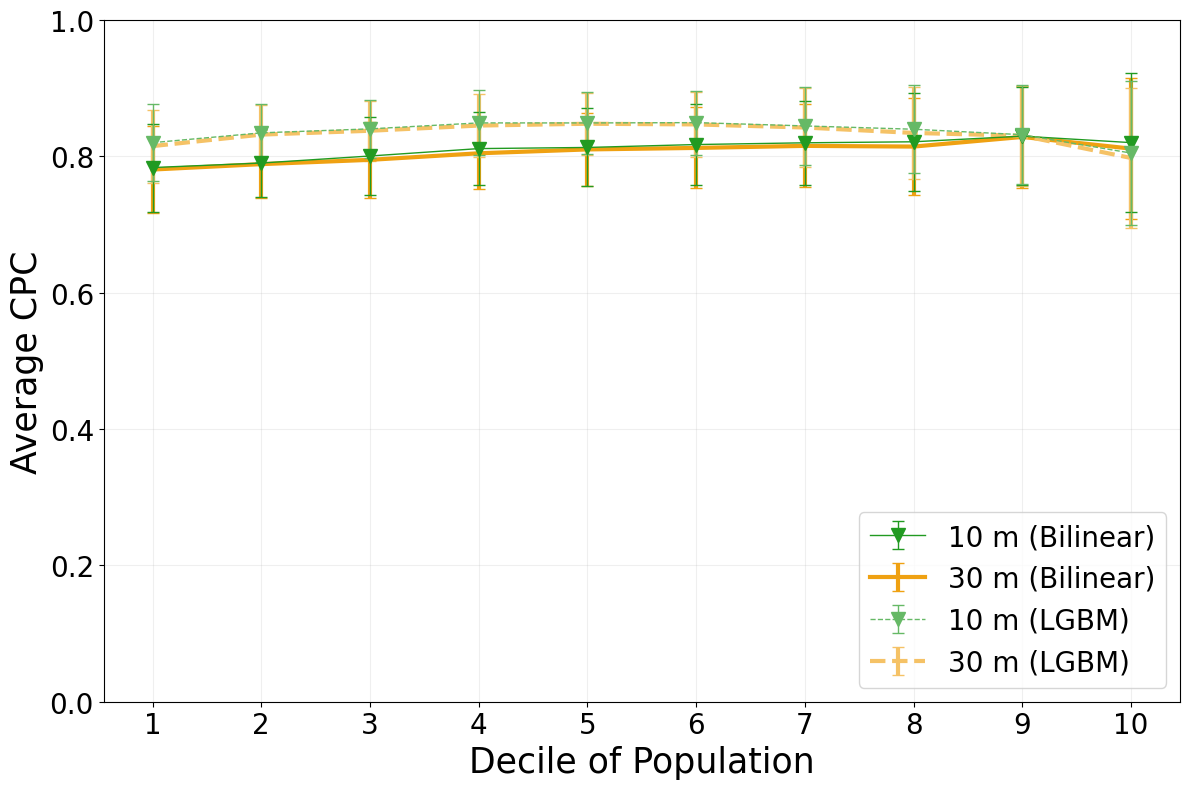

In [18]:
import matplotlib.pyplot as plt
def plot_decile(df, column_name, axisx_label,x_ticklabels, x_ticks,savename):
   fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

   avg_b_s2s,avg_b_l8s,avg_l_s2s,avg_l_l8s = [], [], [], []
   std_b_s2s,std_b_l8s,std_l_s2s,std_l_l8s = [], [], [], []

   table = pd.DataFrame(columns=['decile','count', 'CPC bilinear s2 mean','CPC bilinear l8 mean', 'CPC lgbm s2 mean','CPC lgbm l8 mean'])
   for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      avg_b_s2 = df_temp.h_cpc_bilinear_s2.mean()
      avg_b_l8 = df_temp.h_cpc_bilinear_l8.mean()
      avg_l_s2 = df_temp.h_cpc_lgbm_s2.mean()
      avg_l_l8 = df_temp.h_cpc_lgbm_l8.mean()
      

      avg_b_s2s.append(avg_b_s2)
      avg_b_l8s.append(avg_b_l8)
      avg_l_s2s.append(avg_l_s2)
      avg_l_l8s.append(avg_l_l8)

      std_b_s2 = df_temp.h_cpc_bilinear_s2.std()
      std_b_l8 = df_temp.h_cpc_bilinear_l8.std()
      std_l_s2 = df_temp.h_cpc_lgbm_s2.std()
      std_l_l8 = df_temp.h_cpc_lgbm_l8.std()

      std_b_s2s.append(std_b_s2)
      std_b_l8s.append(std_b_l8)
      std_l_s2s.append(std_l_s2)
      std_l_l8s.append(std_l_l8)

      newrow = pd.DataFrame([[decile, len(df_temp), avg_b_s2, avg_b_l8, avg_l_s2, avg_l_l8]], 
                           columns=['decile', 'count',  'CPC bilinear s2 mean','CPC bilinear l8 mean', 'CPC lgbm s2 mean', 'CPC lgbm l8 mean'])

      table = pd.concat([table, newrow])

   print(table)

   # decile plots
   ax = axes

   ax.errorbar(range(x_ticks), avg_b_s2s, yerr=std_b_s2s, marker='v', capsize=4,
            color='#219a21', label='10 m (Bilinear)', linewidth=1, markersize=10, zorder=3)  

   ax.errorbar(range(x_ticks), avg_b_l8s, yerr=std_b_l8s, capsize=4,
            color='#efa112', label='30 m (Bilinear)', linewidth=3)  # linestyle='--', 
   
   ax.errorbar(range(x_ticks), avg_l_s2s, yerr=std_l_s2s, marker='v', linestyle='--', capsize=4,
            color='#66b966', label='10 m (LGBM)', linewidth=1, markersize=10, zorder=3)  

   ax.errorbar(range(x_ticks), avg_l_l8s, yerr=std_l_l8s, linestyle='--', capsize=4,
            color='#f5c266', label='30 m (LGBM)', linewidth=3)  # linestyle='--', 
   

   ax.set_ylabel('Average CPC', fontsize=25)
   ax.set_xlabel(axisx_label, fontsize=25)
   ax.set_xticks(range(x_ticks))
   ax.set_xticklabels(x_ticklabels)
   ax.set_ylim(0.0,1)
   ax.tick_params(labelsize=20)
   ax.grid(alpha=0.2)

   ax.legend(fontsize=20, loc='lower right')

   plt.subplots_adjust(wspace=0.3)

   plt.tight_layout()
   plt.savefig(savename)

 
plot_decile(home_sum, 'decile', 'Decile of Population', range(1,11), 10, './figs/M1_Population.png')

In [19]:
# flow distance
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

feat = gpd.read_file('/data/M1_NY/CensusTracts/tl_2020_tract20_M1.shp')
feat['centroid_x'] = feat['geometry'].centroid.x
feat['centroid_y'] = feat['geometry'].centroid.y
res_total = pd.merge(left=res_total, right=feat, left_on='h_geocode', right_on='GEOID20')[['w_geocode', 'h_geocode', 'count','prediction_bilinear_s2','prediction_bilinear_l8', 'prediction_lgbm_s2','prediction_lgbm_l8', 'centroid_x', 'centroid_y']]
res_total = res_total.rename(columns={'centroid_x': "h_centroid_x", 'centroid_y':'h_centroid_y'})
res_total = pd.merge(left=res_total, right=feat, left_on='w_geocode', right_on='GEOID20')[['w_geocode', 'h_geocode', 'count','prediction_bilinear_s2','prediction_bilinear_l8', 'prediction_lgbm_s2','prediction_lgbm_l8','h_centroid_x', 'h_centroid_y', 'centroid_x', 'centroid_y']]
res_total = res_total.rename(columns={'centroid_x': "w_centroid_x", 'centroid_y':'w_centroid_y'})
res_total.to_csv('flows_M1_2020_xy.csv')

C:\Users\1OrangeGo\AppData\Local\Temp\ipykernel_22028\2842048200.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feat['centroid_x'] = feat['geometry'].centroid.x
C:\Users\1OrangeGo\AppData\Local\Temp\ipykernel_22028\2842048200.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feat['centroid_y'] = feat['geometry'].centroid.y


In [26]:
from shapely.geometry import Point
import geopy.distance
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)
def haversine(o_x, o_y, d_x, d_y):
    distance = geopy.distance.distance((o_y, o_x), (d_y, d_x)).m

    return distance
res_total['distance'] = res_total.progress_apply(lambda row: haversine(row['h_centroid_x'], row['h_centroid_y'], row['w_centroid_x'], row['w_centroid_y']), axis=1)
res_total['common_bilinear_s2'] = res_total[['prediction_bilinear_s2','count']].min(axis=1)
res_total['common_bilinear_l8'] = res_total[['prediction_bilinear_l8','count']].min(axis=1)
res_total['common_lgbm_s2'] = res_total[['prediction_lgbm_s2','count']].min(axis=1)
res_total['common_lgbm_l8'] = res_total[['prediction_lgbm_l8','count']].min(axis=1)
# breaks = jenkspy.jenks_breaks(res_total['distance'], n_classes=5)
breaks = [0, 10000, 20000, 30000, 40000, 50000, max(res_total['distance'])]
print(breaks)

[0, 10000, 20000, 30000, 40000, 50000, 131521.5573284121]


In [27]:
res_total['cut'] = pd.cut(res_total['distance'],
                        bins=breaks,
                        labels=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'],include_lowest=True)

In [28]:
res_total['f_cpc_bilinear_s2'] = 2* res_total['common_bilinear_s2'] / (res_total['count']+res_total['prediction_bilinear_s2'])
res_total['f_cpc_bilinear_l8'] = 2* res_total['common_bilinear_l8'] / (res_total['count']+res_total['prediction_bilinear_l8'])
res_total['f_cpc_lgbm_s2'] = 2* res_total['common_lgbm_s2'] / (res_total['count']+res_total['prediction_lgbm_s2'])
res_total['f_cpc_lgbm_l8'] = 2* res_total['common_lgbm_l8'] / (res_total['count']+res_total['prediction_lgbm_l8'])
res_total_dis = res_total.iloc[:,2:].groupby('cut').sum()

res_total_dis['cpc_bilinear_s2'] = 2 * res_total_dis['common_bilinear_s2'] / (res_total_dis['count']+res_total_dis['prediction_bilinear_s2'])
res_total_dis['cpc_bilinear_l8'] = 2 * res_total_dis['common_bilinear_l8'] / (res_total_dis['count']+res_total_dis['prediction_bilinear_l8'])
res_total_dis['cpc_lgbm_s2'] = 2 * res_total_dis['common_lgbm_s2'] / (res_total_dis['count']+res_total_dis['prediction_lgbm_s2'])
res_total_dis['cpc_lgbm_l8'] = 2 * res_total_dis['common_lgbm_l8'] / (res_total_dis['count']+res_total_dis['prediction_lgbm_l8'])

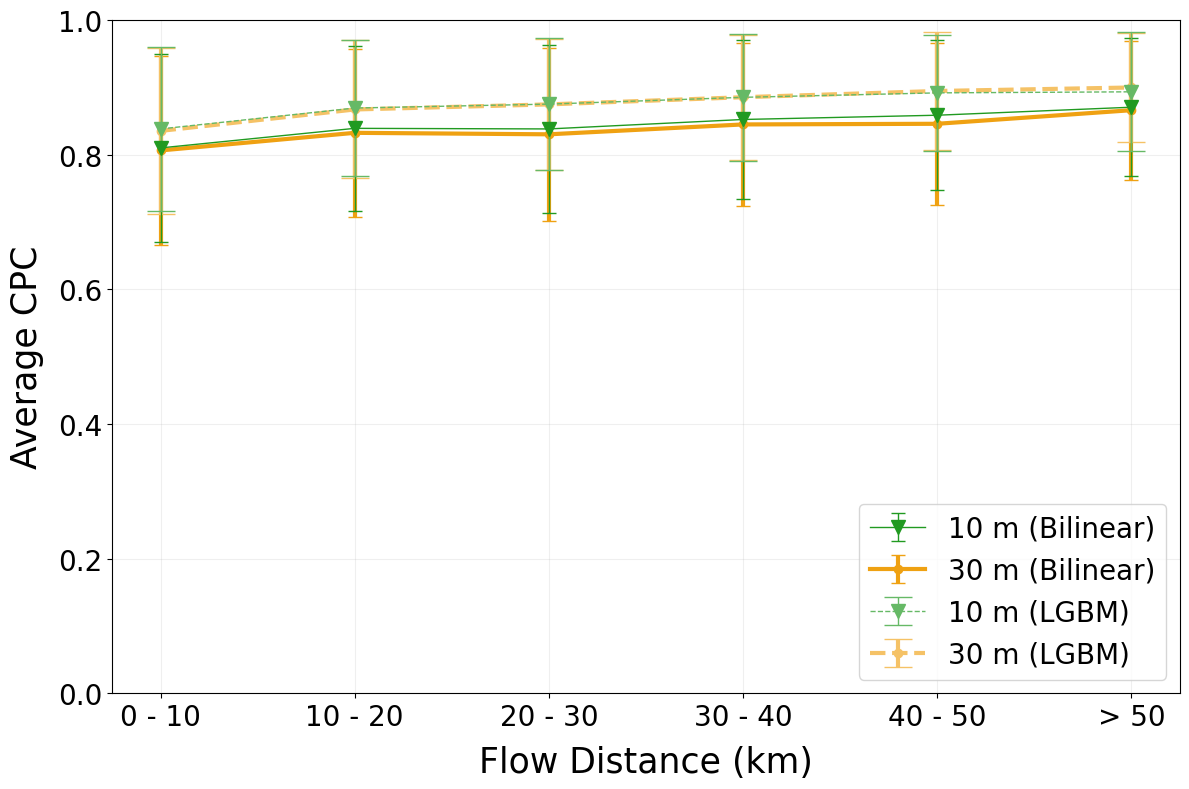

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns


column_name = 'cut'
axisx_label = 'Flow Distance (km)'
x_ticklabels = [ '0 - 10','10 - 20', '20 - 30', '30 - 40', '40 - 50', '> 50']

x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
df = res_total
avg_b_s2s,avg_b_l8s,avg_l_s2s,avg_l_l8s = [], [], [], []
std_b_s2s,std_b_l8s,std_l_s2s,std_l_l8s = [], [], [], []
for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      avg_b_s2 = df_temp.f_cpc_bilinear_s2.mean()
      avg_b_l8 = df_temp.f_cpc_bilinear_l8.mean()
      avg_l_s2 = df_temp.f_cpc_lgbm_s2.mean()
      avg_l_l8 = df_temp.f_cpc_lgbm_l8.mean()
      

      avg_b_s2s.append(avg_b_s2)
      avg_b_l8s.append(avg_b_l8)
      avg_l_s2s.append(avg_l_s2)
      avg_l_l8s.append(avg_l_l8)


      std_b_s2 = df_temp.f_cpc_bilinear_s2.std()
      std_b_l8 = df_temp.f_cpc_bilinear_l8.std()
      std_l_s2 = df_temp.f_cpc_lgbm_s2.std()
      std_l_l8 = df_temp.f_cpc_lgbm_l8.std()

      std_b_s2s.append(std_b_s2)
      std_b_l8s.append(std_b_l8)
      std_l_s2s.append(std_l_s2)
      std_l_l8s.append(std_l_l8)

ax.errorbar(range(x_ticks), avg_b_s2s, yerr=std_b_s2s, marker='v', capsize=5,
      color='#219a21', label='10 m (Bilinear)', linewidth=1, markersize=10, zorder=3)  

ax.errorbar(range(x_ticks), avg_b_l8s, yerr=std_b_l8s, capsize=5,marker='o',
      color='#efa112', label='30 m (Bilinear)', linewidth=3)  # linestyle='--', 

ax.errorbar(range(x_ticks), avg_l_s2s, yerr=std_l_s2s, marker='v', linestyle='--', capsize=10,
      color='#66b966', label='10 m (LGBM)', linewidth=1, markersize=10, zorder=3)  

ax.errorbar(range(x_ticks), avg_l_l8s, yerr=std_l_l8s, linestyle='--', capsize=10,marker='o',
            color='#f5c266', label='30 m (LGBM)', linewidth=3)  # linestyle='--', 

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)

ax.legend(fontsize=20, loc='lower right')

plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
plt.savefig('./figs/M1_flowdis.png')

In [29]:
# flow volume
breaks_i = [0, 20, 40, 60, 80, 100, res_total['count'].max()]
res_total['cut_intensity'] = pd.cut(res_total['count'],
                        bins=breaks_i,
                        labels=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],include_lowest=True)

res_total_intensity = res_total.iloc[:,2:].drop(columns='cut').groupby('cut_intensity').sum()

res_total_intensity['cpc_bilinear_s2'] = 2 * res_total_intensity['common_bilinear_s2'] / (res_total_intensity['count']+res_total_intensity['prediction_bilinear_s2'])
res_total_intensity['cpc_bilinear_l8'] = 2 * res_total_intensity['common_bilinear_l8'] / (res_total_intensity['count']+res_total_intensity['prediction_bilinear_l8'])
res_total_intensity['cpc_lgbm_s2'] = 2 * res_total_intensity['common_lgbm_s2'] / (res_total_intensity['count']+res_total_intensity['prediction_lgbm_s2'])
res_total_intensity['cpc_lgbm_l8'] = 2 * res_total_intensity['common_lgbm_l8'] / (res_total_intensity['count']+res_total_intensity['prediction_lgbm_l8'])


[0, 20, 40, 60, 80, 100, 861.0]


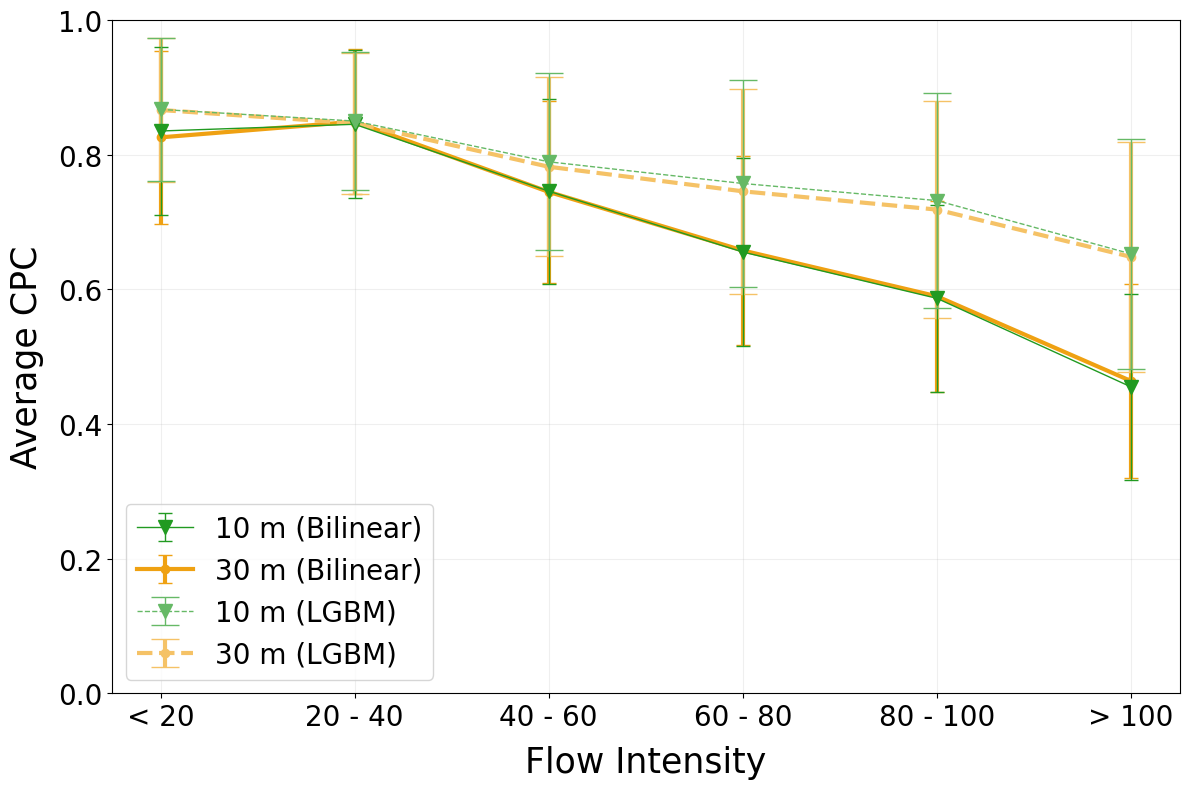

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns


column_name = 'cut_intensity'
axisx_label = 'Flow Intensity'

x_ticklabels = [ '< 20','20 - 40', '40 - 60', '60 - 80', '80 - 100', '> 100']

x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
df = res_total
avg_b_s2s,avg_b_l8s,avg_l_s2s,avg_l_l8s = [], [], [], []
std_b_s2s,std_b_l8s,std_l_s2s,std_l_l8s = [], [], [], []
for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      avg_b_s2 = df_temp.f_cpc_bilinear_s2.mean()
      avg_b_l8 = df_temp.f_cpc_bilinear_l8.mean()
      avg_l_s2 = df_temp.f_cpc_lgbm_s2.mean()
      avg_l_l8 = df_temp.f_cpc_lgbm_l8.mean()
      
      avg_b_s2s.append(avg_b_s2)
      avg_b_l8s.append(avg_b_l8)
      avg_l_s2s.append(avg_l_s2)
      avg_l_l8s.append(avg_l_l8)

      std_b_s2 = df_temp.f_cpc_bilinear_s2.std()
      std_b_l8 = df_temp.f_cpc_bilinear_l8.std()
      std_l_s2 = df_temp.f_cpc_lgbm_s2.std()
      std_l_l8 = df_temp.f_cpc_lgbm_l8.std()

      std_b_s2s.append(std_b_s2)
      std_b_l8s.append(std_b_l8)
      std_l_s2s.append(std_l_s2)
      std_l_l8s.append(std_l_l8)


ax.errorbar(range(x_ticks), avg_b_s2s, yerr=std_b_s2s, marker='v', capsize=5,
      color='#219a21', label='10 m (Bilinear)', linewidth=1, markersize=10, zorder=3)  

ax.errorbar(range(x_ticks), avg_b_l8s, yerr=std_b_l8s, capsize=5,marker='o',
      color='#efa112', label='30 m (Bilinear)', linewidth=3)  # linestyle='--', 

ax.errorbar(range(x_ticks), avg_l_s2s, yerr=std_l_s2s, marker='v', linestyle='--', capsize=10,
      color='#66b966', label='10 m (LGBM)', linewidth=1, markersize=10, zorder=3)  

ax.errorbar(range(x_ticks), avg_l_l8s, yerr=std_l_l8s, linestyle='--', capsize=10,marker='o',
            color='#f5c266', label='30 m (LGBM)', linewidth=3)  # linestyle='--', 

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)

ax.legend(fontsize=20, loc='lower left')

plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
